# Assignment 1
### Tourists vs. New Yorker CitiBike Visualization

In [62]:
# my usual imports and setups
import matplotlib.pylab as plt 
import pandas as pd
import numpy as np
%matplotlib inline

import os
from datetime import datetime, timedelta
import time
import scipy.stats
from getCitiBike import getCitiBikeCSV #custom script to get citi bike data for a given month

In [27]:
def getCitiBikeCSV(date):
    ''' 
    This function returns citi bike data for a given month(s)
    
    Parameters
    ----------
    date: string
        Pass one month by inputting format <YYYY><MM>; EX: 201801
        Pass month range by inputting format <YYYY><M1M1><M2M2>; EX: 20180103
        
    Returns
    ----------
    csv: table
        dumps it into your PUIDATA folder
    '''
    path = "https://s3.amazonaws.com/tripdata/{}-citibike-tripdata.csv.zip".format(str(date))
    os.system('curl -O ' + path)
    currentpath = []
    currentpath.append(os.getcwd())
    os.system('unzip -u '+currentpath[0]+'/'+ path.split('/')[-1]+ ' -d $PUIDATA')
    print('Downloaded',path.split('/')[-1].split('.z')[0], 'to your PUIDATA folder!')

In [28]:
datestring = '201809' # Download September data
getCitiBikeCSV(datestring)
df = pd.read_csv(os.getenv("PUIDATA") + "/" + datestring + '-citibike-tripdata.csv', parse_dates=['starttime','stoptime'])

Downloaded 201809-citibike-tripdata.csv to your PUIDATA folder!


In [31]:
df['time'] = df.starttime.apply(lambda x: x.time()) #get time object from starttime
df['day_of_week'] = df.starttime.apply(lambda x: x.weekday()) #Monday is a 0 

In [113]:
def get_hour(mytime):
    time_str = str(mytime)
    h, m, s = time_str.split(':')
    return(int(h) * 3600 + int(m) * 60 + float(s))/3600

In [114]:
#convert time to total hours (from start of day)
df['total_hours'] = df.time.apply(lambda x: get_hour(x))
df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,time,day_of_week,total_hours
0,1635,2018-09-01 00:00:05.269,2018-09-01 00:27:20.634,252.0,MacDougal St & Washington Sq,40.732264,-73.998522,366.0,Clinton Ave & Myrtle Ave,40.693261,-73.968896,25577,Subscriber,1980,1,00:00:05.269000,5,0.001464
1,132,2018-09-01 00:00:11.281,2018-09-01 00:02:23.481,314.0,Cadman Plaza West & Montague St,40.693830,-73.990539,3242.0,Schermerhorn St & Court St,40.691029,-73.991834,34377,Subscriber,1969,0,00:00:11.281000,5,0.003134
2,3337,2018-09-01 00:00:20.649,2018-09-01 00:55:58.547,3142.0,1 Ave & E 62 St,40.761227,-73.960940,3384.0,Smith St & 3 St,40.678724,-73.995991,30496,Subscriber,1975,1,00:00:20.649000,5,0.005736
3,436,2018-09-01 00:00:21.746,2018-09-01 00:07:38.583,308.0,St James Pl & Oliver St,40.713079,-73.998512,3690.0,Park Pl & Church St,40.713342,-74.009355,28866,Subscriber,1984,2,00:00:21.746000,5,0.006041
4,8457,2018-09-01 00:00:27.315,2018-09-01 02:21:25.308,345.0,W 13 St & 6 Ave,40.736494,-73.997044,380.0,W 4 St & 7 Ave S,40.734011,-74.002939,20943,Customer,1994,1,00:00:27.315000,5,0.007588


In [118]:
#divide into weekend vs. weekday
citibikeWeekday = df[df.day_of_week < 5]
citibikeWeekend = df[df.day_of_week >= 5]

In [119]:
#eliminate unnecessary columns and sort
citibikeWeekday = citibikeWeekday[['usertype','total_hours']]
citibikeWeekday.sort_values('total_hours', inplace=True)

citibikeWeekend = citibikeWeekend[['usertype','total_hours']]
citibikeWeekend.sort_values('total_hours', inplace=True)

In [121]:
bins = np.linspace(0,24,144) #split it up into 10 minute intervals

# Aggregate and sum the WEEKDAY tourists and locals by bin
tourists_weekday = citibikeWeekday[citibikeWeekday.usertype != 'Subscriber'].total_hours.groupby(pd.cut(citibikeWeekday[citibikeWeekday.usertype != 'Subscriber'].total_hours, 
                                                 bins)).agg([np.count_nonzero]).cumsum()
NY_locals_weekday = citibikeWeekday[citibikeWeekday.usertype == 'Subscriber'].total_hours.groupby(pd.cut(citibikeWeekday[citibikeWeekday.usertype == 'Subscriber'].total_hours, 
                                                 bins)).agg([np.count_nonzero]).cumsum()

# Aggregate and sum the WEEKEND tourists and locals by bin
tourists_weekend = citibikeWeekend[citibikeWeekend.usertype != 'Subscriber'].total_hours.groupby(pd.cut(citibikeWeekend[citibikeWeekend.usertype != 'Subscriber'].total_hours, 
                                                 bins)).agg([np.count_nonzero]).cumsum()
NY_locals_weekend = citibikeWeekend[citibikeWeekend.usertype == 'Subscriber'].total_hours.groupby(pd.cut(citibikeWeekend[citibikeWeekend.usertype == 'Subscriber'].total_hours, 
                                                 bins)).agg([np.count_nonzero]).cumsum()

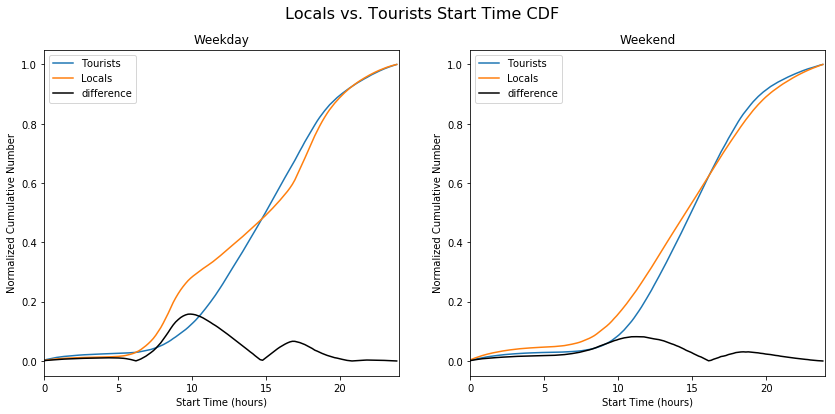

In [162]:
fig = plt.figure(figsize=(14,6))
axs = fig.subplots(1,2)
ax1 = axs[0]
ax2 = axs[1]

fig.suptitle('Locals vs. Tourists Start Time CDF', fontsize=16)

ax1.plot(bins[:-1], tourists_weekday / tourists_weekday.max(), label = "Tourists")
ax1.plot(bins[:-1], NY_locals_weekday / NY_locals_weekday.max(), label = "Locals")
ax1.plot(bins[:-1], np.abs(NY_locals_weekday / NY_locals_weekday.max() - tourists_weekday / tourists_weekday.max()), 'k-',
        label = "difference")
ax1.set_title("Weekday")

ax2.plot(bins[:-1], tourists_weekend / tourists_weekend.max(), label = "Tourists")
ax2.plot(bins[:-1], NY_locals_weekend / NY_locals_weekend.max(), label = "Locals")
ax2.plot(bins[:-1], np.abs(NY_locals_weekend / NY_locals_weekend.max() - tourists_weekend / tourists_weekend.max()), 'k-',
        label = "difference")
ax2.set_title("Weekend")

for ax in axs:
    ax.set_xlabel("Start Time (hours)")
    ax.set_ylabel("Normalized Cumulative Number")
    ax.set_xlim(0,24)
    ax.legend();

fig.savefig('Locals_vs_Tourists_Start_time.png')

**Figure 1:** These figures show that the start time for tourists vs New Yorkers varies differently on the weekdays. The greatest difference between the two groups (~20%) happens right before 10am, which makes sense because it aligns with the morning commute. Likewise, there is another peak around the evening commute (~17 hours). This relationship is minimized during the weekend, as symbolized by the line of difference. 